## konlp: 한글 영화 감상평 분류

__한글 데이터의 특징__ <br>
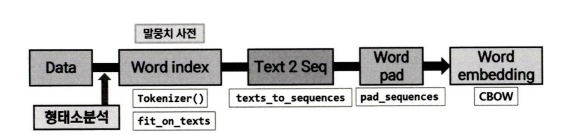

영어는 단어 하나가 하나의 형태소로 구성되어 있어 띄어쓰기 단위로 형태소를 파악할 수 있지만, 한국어는 하나의 띄어쓰기 단위에 여러 형태소가 모여있다. 

ex. '오늘도 좋은 하루 보내세요' <br>
오늘도 = 오늘 + 도<br>
좋은 = 좋다 + 은<br>
하루 = 하루<br>
보내세요 = 보내다 + 시 + 어요<br>

한국어는 Word2Vec을 진행하기 전에 `형태소 분석`을 통해 의미 있는 단어를 추려내 학습을 시킨다. 즉, 조사나 종결어미처럼 별다른 의미가 없는 형태소는 배제하고, 의미있는 형태소들로 말뭉치 사전을 만든다. 

### 1. 기본 라이브러리 호출

In [32]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 2. 데이터 준비

In [33]:
train = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\2.DL\3.NLP\datasets\ratings_train.txt', sep='\t')
test = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\2.DL\3.NLP\datasets\ratings_test.txt', sep='\t')

train.shape, test.shape

((150000, 3), (50000, 3))

In [34]:
train[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


> id, documnet, label 총 3개의 열로 구성. id는 감성분류를 수행하는데 도움이 되지 않으므로 무시. 종속변수는 label(긍정1, 부정0)

> 한글데이터와 영어 데이터의 차이를 알 수 있다. 예를 들어 인덱스2번 샘플은 띄어쓰기 하지 않아도 글을 쉽게 이해할 수 있는 한국어의 특성으로 인해 띄어쓰기가 되어 있지 않다.

In [35]:
test[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 3. 데이터 전처리

#### 3-1. 결측치의 처리

In [36]:
train['document'].nunique(), train['label'].nunique()

(146182, 2)

> 150000개의 샘플 중 중복을 제거하면 146182개 (=즉, 약 4000개의 중복 샘플이 존재)

In [37]:
# 중복 샘플 제거
train.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플 수:', len(train))

총 샘플 수: 146183


> 중복 데이터 제거되었다.

<Axes: xlabel='label'>

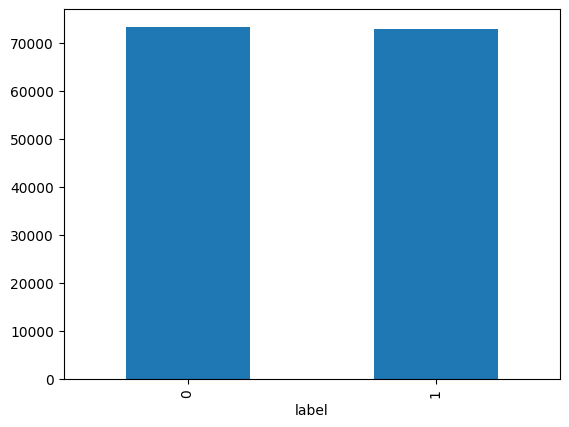

In [38]:
train['label'].value_counts().plot(kind='bar')

> 약 146000개 영화 리뷰 샘플이 존재하는데, 긍정 부정 둘다 72000개 샘플이 존재하여 레이블의 분포가 균일한 것처럼 보인다. 

In [39]:
print(train.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


> label 0이 근소하게 많다. null값이 있는지 확인해보기

In [40]:
print(train.isnull().values.any())

True


> 결측치가 존재한다. 어떤 열에 존재하는지 확인해보기

In [41]:
print(train.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [42]:
train[train['document'].isnull() == True]

,id,document,label
25857,2172111,NaN,1


> 25857 인덱스에 null값 존재

In [43]:
# null값이 존재하는 행 제거
train = train.dropna(how='any')

In [44]:
# null값이 존재하는 지 확인
print(train.isnull().any())

id          False
document    False
label       False
dtype: bool


In [45]:
print('총 샘플 수:', len(train))

총 샘플 수: 146182


#### 3-2. 특수문자 제거하기

- 영어 데이터의 예시
    - 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]이다. 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있다.

In [46]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


- 이와 같은 원리를 한국 데이터에 적용하고 싶다면, 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 된다. 
- 링크 : https://www.unicode.org/charts/PDF/U3130.pdf
    - 자음 : ㄱ ~ ㅎ: 3131 ~ 314E
    - 모음 : ㅏ ~ ㅣ: 314F ~ 3163
    
- 완성형 한글의 범위는 가~힣 과 같이 사용된다.

In [53]:
text = '아 더빙.. 진짜 짜증나네요 목소리'
print(re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', text))

아더빙진짜짜증나네요목소리


In [59]:
def clean_text(inputString):
  text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
  return text_rmv

In [61]:
# 한글과 공백을 제외하고 모두 제거
train['document'] = train['document'].apply(clean_text)
train[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


> 띄어쓰기는 유지하면서 온점과 같은 구두점 등은 제거.

> 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈 값이 되었을 것이다. train데이터에 공백만 있거나 빈 값을 가진 행이 있다면 null값으로 변경하도록 하고, null값이 존재하는지 확인

In [62]:
train['document'] = train['document'].str.replace('^ +', '')
train['document'].replace('', np.nan, inplace=True)
print(train.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [71]:
test['document'][:5]

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
Name: document, dtype: object

In [74]:
test['document'] = test['document'].apply(clean_text)
test['document'][:5]

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은     나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임    돈주고 보기에는    
4    3D만 아니었어도 별 다섯 개 줬을텐데   왜 3D로 나와서 제 심기를 불편하게 하죠  
Name: document, dtype: object

In [75]:
test['document'] = test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 49157


####  3-3. 토큰화
- 불용어 제거

In [77]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [78]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

> Okt는 KoNLPy에서 제공하는 형태소 분석기이다. 한국어를 토큰화할때는 영어처럼 띄어쓰기 기준으로 토큰화하는 것이 아니라, 주로 형태소 분석기를 사용.  stem=True를 사용하면 일정수준 정규화를 수행. 

In [79]:
# 형태소 분석기를 사용 + 불용어 제거 한 결과 저장
X_train = []

for sentence in tqdm(train['document']):
    # 형태소 단위로 분리
    tokenized_sentence = okt.morphs(sentence, stem=True)
    # 불용어 제거
    stopwords_removed_sentence = [ word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 146182/146182 [04:30<00:00, 539.61it/s]


In [80]:
# 상위 3개만 출력
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [81]:
# test 데이터도 동일하게 진행
X_test = []

for sentence in tqdm(test['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [ word for word in tokenized_sentence if not word in stopwords ]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 49157/49157 [01:38<00:00, 500.29it/s]


#### 3-4. 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행

In [83]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

> 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여. 이는 tokenizer.word_index를 출력하여 확인 가능

In [86]:
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '을': 3,
 '없다': 4,
 '이다': 5,
 '있다': 6,
 '좋다': 7,
 '너무': 8,
 '다': 9,
 '정말': 10,
 '되다': 11,
 '재밌다': 12,
 '적': 13,
 '만': 14,
 '같다': 15,
 '진짜': 16,
 '로': 17,
 '점': 18,
 '아니다': 19,
 '않다': 20,
 '에서': 21,
 '만들다': 22,
 '연기': 23,
 '나오다': 24,
 '것': 25,
 '평점': 26,
 '내': 27,
 '최고': 28,
 '그': 29,
 '나': 30,
 '안': 31,
 '인': 32,
 '스토리': 33,
 '생각': 34,
 '못': 35,
 '왜': 36,
 '드라마': 37,
 '게': 38,
 '1': 39,
 '감동': 40,
 '사람': 41,
 '보고': 42,
 '이렇다': 43,
 '말': 44,
 '고': 45,
 '아깝다': 46,
 '더': 47,
 '아': 48,
 '때': 49,
 '배우': 50,
 'ㅋㅋ': 51,
 '거': 52,
 '감독': 53,
 '그냥': 54,
 '재미있다': 55,
 '요': 56,
 '내용': 57,
 '재미': 58,
 '중': 59,
 '뭐': 60,
 '까지': 61,
 '주다': 62,
 '자다': 63,
 '하고': 64,
 '지루하다': 65,
 '재미없다': 66,
 '시간': 67,
 '수': 68,
 '쓰레기': 69,
 '가다': 70,
 '네': 71,
 '모르다': 72,
 '들다': 73,
 '그렇다': 74,
 '싶다': 75,
 '10': 76,
 '지': 77,
 '작품': 78,
 '사랑': 79,
 '알다': 80,
 '하나': 81,
 '다시': 82,
 '마지막': 83,
 '볼': 84,
 '2': 85,
 '이건': 86,
 '오다': 87,
 'ㅋ': 88,
 '저': 89,
 '정도': 90,
 '완전': 91,
 'ㅋㅋㅋ': 92,
 '많다': 93,

> 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여. 높은 정수가 부여된 단어들은 빈도수가 매우 낮다는 것을 의미. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 한다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [85]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s 번 이하인 희귀 단어의 수 : %s'% (threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기: 47559
등장 빈도가 2 번 이하인 희귀 단어의 수 : 27280
단어 집합에서 희귀 단어의 비율: 57.36033137786749
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.031626857542986


In [87]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 20280


In [88]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [89]:
print(X_train[:3])

[[48, 469, 16, 267, 678], [933, 470, 42, 625, 1, 220, 1490, 23, 984, 696, 20], [388, 2510, 5192, 6479, 2, 227, 9]]


In [90]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

#### 3-5. 빈 샘플(empty samples) 제거
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거하는 작업을 할 것.

In [98]:
drop_train = [ index for index, sentence in enumerate(X_train) if len(sentence) < 1]
np.array(drop_train)

array([    28,    416,    668,   1156,   1355,   1555,   1582,   1721,
         2319,   2336,   2639,   2958,   3459,   3871,   3898,   3933,
         4313,   4732,   4836,   4873,   5053,   5826,   7021,   7187,
         8202,   8915,   9614,   9720,  10356,  10389,  10453,  10661,
        11039,  11386,  11739,  12041,  12294,  12662,  12736,  12843,
        12973,  13782,  13870,  14484,  14584,  14701,  15519,  15611,
        15686,  16881,  16974,  17659,  18107,  18704,  18733,  19395,
        19636,  19767,  19960,  20529,  20869,  21032,  21422,  21784,
        22913,  22938,  24321,  24728,  24762,  24773,  25019,  25179,
        25288,  26011,  26452,  26467,  27269,  27659,  28579,  28642,
        28769,  28793,  28980,  29109,  29730,  29744,  29795,  30092,
        30367,  30460,  30808,  31269,  31423,  32169,  32659,  33075,
        34226,  34307,  34323,  34427,  34803,  35133,  36476,  37320,
        37324,  37449,  37708,  37792,  37951,  38457,  39139,  39499,
      

In [105]:
for drop in np.array(drop_train):
    X_train[drop].drop(axis=0, inplace=True)

AttributeError: 'list' object has no attribute 'drop'

In [101]:
# 빈 샘플들은 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (146182,) + inhomogeneous part.